# FIRMS + NOMINATIM API


In [14]:
# Importing libraries

# from typing import Literal
import geopandas as gpd

import pandas as pd

from typing import Literal
from io import StringIO
import requests
import logging
from functools import lru_cache

FIRMS_API_URL = "https://firms.modaps.eosdis.nasa.gov"
FIRMS_MAP_KEY = "YOUR_MAP_KEY_HERE"


In [15]:
# Functions for FIRMS API

"""""" """""" """""" """""" """""" """""" """""" """"" """ """"
    Function for checking FIRMS API status
""" """ """ """ """ """ """ """ """ """ """ """ """ """ """ ""

def get_account_status(map_key: str = FIRMS_MAP_KEY):
    status_url = f"{FIRMS_API_URL}/mapserver/mapkey_status/?MAP_KEY={map_key}"

    try:
        df = pd.read_json(status_url, typ="series")
    except ValueError:
        # possible error, wrong MAP_KEY value, check for extra quotes, missing letters
        print("There is an issue with the query. \nTry in your browser: %s" % status_url)

    return df


def get_current_transaction_count(map_key: str = FIRMS_MAP_KEY):
    status_url = f"{FIRMS_API_URL}/mapserver/mapkey_status/?MAP_KEY={map_key}"

    count = 0

    try:
        df = pd.read_json(status_url, typ="series")
        count = df["current_transactions"]

    except ValueError:
        print("Error in our call.")

    return count


"""""" """""" """""" """""" """""" """""" """""" """"" """ """"
    Function for creating FIRMS CSV data URLs via FastAPI
""" """ """ """ """ """ """ """ """ """ """ """ """ """ """ ""

days_ago_list = Literal[1, 2, 3, 4, 5, 6, 7, 8]

def create_firms_csv_urls(
    days: days_ago_list = 3,
) -> tuple[str, str, str]:
    
    firms_csv_data_urls = (
        f"{FIRMS_API_URL}/api/area/csv/{FIRMS_MAP_KEY}/MODIS_NRT/world/{days}",
        f"{FIRMS_API_URL}/api/area/csv/{FIRMS_MAP_KEY}/VIIRS_NOAA20_NRT/world/{days}",
        f"{FIRMS_API_URL}/api/area/csv/{FIRMS_MAP_KEY}/VIIRS_SNPP_NRT/world/{days}",
    )

    return firms_csv_data_urls


"""""" """""" """""" """""" """""" """""" """""" """"" 
    Functions for reading FIRMS CSV data from URLs
""" """ """ """ """ """ """ """ """ """ """ """ """ ""

def read_firm_csv(
    url: str,
) -> pd.DataFrame:
    
    content = fetch_csv_content(url)
    
    return process_csv_data(content)


def fetch_csv_content(url: str) -> StringIO:
    
    try:
        response = requests.get(url)
        response.raise_for_status()
        return StringIO(response.content.decode("utf-8"))

    except (requests.HTTPError, OSError) as e:
        logging.error(f"Error fetching CSV content: {e}")
        raise


def process_csv_data(
    csv_content: StringIO,
) -> pd.DataFrame:
    
    try:
        data = pd.read_csv(csv_content, dtype={"acq_date": str, "acq_time": str})

        # Data processing logic...
        data["high_confidence"] = False  # Initialize the column with False

        # Mark the rows that meet the confidence criteria
        if pd.api.types.is_numeric_dtype(data["confidence"]):
            data.loc[data["confidence"] >= 70, "high_confidence"] = True
            data.rename(
                columns={
                    "brightness": "brightness_a",
                    "bright_t31": "brightness_b",
                },
                inplace=True,
            )
        elif pd.api.types.is_string_dtype(data["confidence"]):
            data.loc[data["confidence"].isin(["nominal", "high"]), "high_confidence"] = True
            data.rename(
                columns={
                    "bright_ti4": "brightness_a",
                    "bright_ti5": "brightness_b",
                },
                inplace=True,
            )

        # Now apply the transformation to all rows, without filtering
        # data[date_column] = pd.to_datetime(data[date_column]).dt.strftime('%Y-%m-%d')
        data["acq_time"] = data["acq_time"].str.pad(width=4, side="left", fillchar="0")

        data["acq_datetime"] = pd.to_datetime(
            data["acq_date"] + " " + data["acq_time"].astype(str).str.zfill(4),
            format="%Y-%m-%d %H%M%S",
        )

        data["satellite"] = data["satellite"].astype(str)
        data["confidence"] = data["confidence"].astype(str)

        return data

    except pd.errors.ParserError as e:
        logging.error(f"Error processing CSV data: {e}")
        raise


"""""" """""" """""" """""" """""" """""" """""" """"" """ """" """ """ """ """ """ """" """"""
    Functions for combining FIRMS CSV data directly from URLs and convert to GeoDataFrame
""" """ """ """ """ """ """ """ """ """ """ """ """ """ """ "" """""" " " """"" """ """ """""

@lru_cache()
def convert_firms_urls_to_combined_gdf(
    firms_urls: tuple[str, str, str]
) -> gpd.GeoDataFrame:
    
    single_df = pd.DataFrame()

    combined_df_list = [single_df]

    for url in firms_urls:
        # print(url)
        df = read_firm_csv(url)
        combined_df_list.append(df)

    combined_df = pd.concat(combined_df_list, ignore_index=True)

    # Assuming there's a column named 'high_confidence' in the DataFrame
    combined_df = combined_df[combined_df["high_confidence"]].copy()

    # Remove duplicates if you want to clean up the data, otherwise just save it
    # Specify the columns to determine uniqueness
    unique_columns = [
        "latitude",
        "longitude",
        "acq_datetime",
        "confidence",
        "version",
    ]

    combined_df_export = combined_df.drop_duplicates(subset=unique_columns, keep="last").copy()

    # Sort the DataFrame by date and time
    combined_df_export.sort_values(["acq_datetime"], inplace=True)
    combined_df_export.drop(
        ["scan", "track", "acq_date", "acq_time", "brightness_a", "brightness_b", "daynight"], axis=1, inplace=True
    )

    gdf = gpd.GeoDataFrame(
        combined_df_export,
        geometry=gpd.points_from_xy(combined_df_export.longitude, combined_df_export.latitude),
        crs="EPSG:4326",
    )

    return gdf


In [16]:
# Functions for Nominatim API

nominatim_country_codes = Literal[
    'AD', 'AE', 'AF', 'AG', 'AI', 'AL', 'AM', 'AO', 'AQ', 'AR', 'AS', 'AT', 'AU', 'AW', 'AX', 'AZ', 
    'BA', 'BB', 'BD', 'BE', 'BF', 'BG', 'BH', 'BI', 'BJ', 'BL', 'BM', 'BN', 'BO', 'BQ', 'BR', 'BS', 
    'BT', 'BV', 'BW', 'BY', 'BZ', 'CA', 'CC', 'CD', 'CF', 'CG', 'CH', 'CI', 'CK', 'CL', 'CM', 'CN', 
    'CO', 'CR', 'CU', 'CV', 'CW', 'CX', 'CY', 'CZ', 'DE', 'DJ', 'DK', 'DM', 'DO', 'DZ', 'EC', 'EE', 
    'EG', 'EH', 'ER', 'ES', 'ET', 'FI', 'FJ', 'FK', 'FM', 'FO', 'FR', 'GA', 'GB', 'GD', 'GE', 'GF', 
    'GG', 'GH', 'GI', 'GL', 'GM', 'GN', 'GP', 'GQ', 'GR', 'GS', 'GT', 'GU', 'GW', 'GY', 'HK', 'HM', 
    'HN', 'HR', 'HT', 'HU', 'ID', 'IE', 'IL', 'IM', 'IN', 'IO', 'IQ', 'IR', 'IS', 'IT', 'JE', 'JM', 
    'JO', 'JP', 'KE', 'KG', 'KH', 'KI', 'KM', 'KN', 'KP', 'KR', 'KW', 'KY', 'KZ', 'LA', 'LB', 'LC', 
    'LI', 'LK', 'LR', 'LS', 'LT', 'LU', 'LV', 'LY', 'MA', 'MC', 'MD', 'ME', 'MF', 'MG', 'MH', 'MK', 
    'ML', 'MM', 'MN', 'MO', 'MP', 'MQ', 'MR', 'MS', 'MT', 'MU', 'MV', 'MW', 'MX', 'MY', 'MZ', 'NA', 
    'NC', 'NE', 'NF', 'NG', 'NI', 'NL', 'NO', 'NP', 'NR', 'NU', 'NZ', 'OM', 'PA', 'PE', 'PF', 'PG', 
    'PH', 'PK', 'PL', 'PM', 'PN', 'PR', 'PS', 'PT', 'PW', 'PY', 'QA', 'RE', 'RO', 'RS', 'RU', 'RW', 
    'SA', 'SB', 'SC', 'SD', 'SE', 'SG', 'SH', 'SI', 'SJ', 'SK', 'SL', 'SM', 'SN', 'SO', 'SR', 'ST', 
    'SS', 'SV', 'SX', 'SY', 'SZ', 'TC', 'TD', 'TF', 'TG', 'TH', 'TJ', 'TK', 'TL', 'TM', 'TN', 'TO', 
    'TR', 'TT', 'TV', 'TW', 'TZ', 'UA', 'UG', 'UM', 'US', 'UY', 'UZ', 'VA', 'VC', 'VE', 'VG', 'VI', 
    'VN', 'VU', 'WF', 'WS', 'XK', 'YE', 'YT', 'ZA', 'ZM', 'ZW'
]


"""""" """""" """""" """""" """""" """""" """""" """"" """ """""" """
    Function for creating a Nominatim search url and convert it
""" """ """ """ """ """ """ """ """ """ """ """ """ """ """ """""" ""

# Fetch OSM data from Nominatim API
def create_nominatim_search_url(
    country_code: nominatim_country_codes = "BJ",
):
    
    NOMINATIM_SEARCH_ENDPOINT = "https://nominatim.openstreetmap.org/search"
    
    params = {
        "namedetails": 1,
        "polygon_geojson": 1,
        "hierarchy": 1,
        "addresstype": "country",
    }

    params_query = "&".join(f"{param_name}={param_value}" for param_name, param_value in params.items())
    nominatim_search_url = (
        f"{NOMINATIM_SEARCH_ENDPOINT}?q={country_code}&featureType=country&{params_query}&format=geojson"
    )
    return nominatim_search_url


# Convert the queried url to a GeoDataFrame
def convert_search_url(nominatim_search_url: str):
    gdf = gpd.read_file(nominatim_search_url)
    gdf = gdf.to_crs(epsg=4326)

    # get the extend of the GeoDataFrame
    gdf_extend = gdf.total_bounds

    # get the centroid of the GeoDataFrame
    gdf_centroid = gdf.to_crs("+proj=cea").centroid.to_crs(gdf.crs)
    gdf_centroid = list(gdf_centroid.total_bounds)

    # get the center of the GeoDataFrame
    center_x = (gdf_centroid[0] + gdf_centroid[2]) / 2  # Average of minx and maxx
    center_y = (gdf_centroid[1] + gdf_centroid[3]) / 2  # Average of miny and maxy
    gdf_center_coors = [center_y, center_x]

    return gdf, gdf_extend, gdf_center_coors


transaction_limit             1000
current_transactions             0
transaction_interval    10 minutes
dtype: object

 ('https://firms.modaps.eosdis.nasa.gov/api/area/csv/fb378e54aacb1d02418559b897c26baf/MODIS_NRT/world/2', 'https://firms.modaps.eosdis.nasa.gov/api/area/csv/fb378e54aacb1d02418559b897c26baf/VIIRS_NOAA20_NRT/world/2', 'https://firms.modaps.eosdis.nasa.gov/api/area/csv/fb378e54aacb1d02418559b897c26baf/VIIRS_SNPP_NRT/world/2')

Used '0' transactions.


<Axes: >

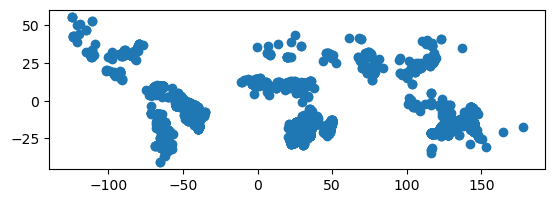

In [18]:
# Testing FIRMS functions

accountStatus = get_account_status()
print(accountStatus)

start_count = get_current_transaction_count()

firms_urls = create_firms_csv_urls(days=2)
print("\n", firms_urls)

firms_combined_gdf = convert_firms_urls_to_combined_gdf(firms_urls)

end_count = get_current_transaction_count()
print("\nUsed '%i' transactions." % (end_count - start_count))

# Plot the result
firms_combined_gdf.plot()


[ 0.776667   6.0398696  3.8451454 12.4092028]
[9.568720251451373, 2.3351835256932465]


<Axes: >

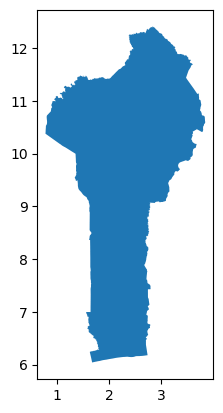

In [19]:
# Testing Nominatim functions

# get the noninatim url
query_url = create_nominatim_search_url()

# test the query_result function
country_gdf, country_extend, country_center_coors = convert_search_url(query_url)

# Print the extend
print(country_extend)

# Print the center
print(country_center_coors)

# Plot the result
country_gdf.plot()


In [21]:
# Functions to filter FIRMS points (data) by Nominatim country boundary

def filter_firms_points_within_country_area(firms_gdf, country_gdf):
    """
    Filters points from a GeoDataFrame that are within the polygons of another GeoDataFrame.

    :param points_gdf: GeoDataFrame containing points.
    :param area_gdf: GeoDataFrame containing multipolygons.
    :return: GeoDataFrame containing only the points that are inside the specified area(s).
    """
    # Ensure the dataframes have the same coordinate reference system (CRS)
    if firms_gdf.crs != country_gdf.crs:
        firms_gdf = firms_gdf.to_crs(country_gdf.crs)

    # Filter points that are within the polygons
    # This creates a boolean series that is True for points within the area
    within_area = firms_gdf.geometry.apply(lambda point: any(point.within(polygon) for polygon in country_gdf.geometry))

    # Use this boolean series to filter the points
    filtered_gdf = firms_gdf[within_area]

    return filtered_gdf


<Axes: >

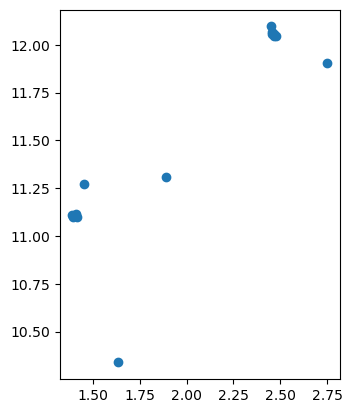

In [22]:
filtered_firms_points = filter_firms_points_within_country_area(firms_combined_gdf, country_gdf)

# Display the result
filtered_firms_points

# Plot the result
filtered_firms_points.plot()
